In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno 
import re
import seaborn as sns
import geopandas as gp
from shapely import wkt

sns.set()

1) Carga del dataset

2) Eleccion de departamentos de la zona de CABA

3) Datos nulos

4) Rescate de valores nulos usando regex en:

* Titulo
* Descripción
* URL 

5) Amenities usando regex:
* Pileta
* Cochera
* Parrilla 
* SUM

6) Verificacion de la calidad de los datos

7) Visualizacion de distribucion de los datos

8) Tratamiento de valores minimos y outliers 

9) Imputacion de valores nulos en las columnas seleccionadas

10) Cercanias con diferentes puntos de la ciudad

11) Dummies de variables categoricas

12) Correlacion de variables

13) Modelos de regresion

14) Matriz de R2 de cada modelo

15) Matriz de R2 Score de cada modelo usando en test

In [2]:
df = pd.read_csv('C:/Users/Lucas/Desktop/ar_properties.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1000000 non-null  object 
 1   ad_type          1000000 non-null  object 
 2   start_date       1000000 non-null  object 
 3   end_date         1000000 non-null  object 
 4   created_on       1000000 non-null  object 
 5   lat              849062 non-null   float64
 6   lon              847640 non-null   float64
 7   l1               1000000 non-null  object 
 8   l2               1000000 non-null  object 
 9   l3               947081 non-null   object 
 10  l4               235216 non-null   object 
 11  l5               4687 non-null     object 
 12  l6               0 non-null        float64
 13  rooms            527516 non-null   float64
 14  bedrooms         469377 non-null   float64
 15  bathrooms        773180 non-null   float64
 16  surface_total    40

In [4]:
df.l1.value_counts(normalize=True)

Argentina         0.984259
Uruguay           0.014844
Estados Unidos    0.000725
Brasil            0.000172
Name: l1, dtype: float64

In [5]:
df.currency.value_counts(normalize=True)

USD    0.782251
ARS    0.215966
UYU    0.001648
PEN    0.000134
Name: currency, dtype: float64

In [6]:
df.l2.value_counts(normalize=True)

Capital Federal                 0.253145
Buenos Aires Costa Atlántica    0.170931
Bs.As. G.B.A. Zona Norte        0.141556
Bs.As. G.B.A. Zona Sur          0.118931
Santa Fe                        0.087835
Bs.As. G.B.A. Zona Oeste        0.074995
Córdoba                         0.058277
Buenos Aires Interior           0.022790
Neuquén                         0.011092
Mendoza                         0.009942
Maldonado                       0.008760
Entre Ríos                      0.006033
Río Negro                       0.005116
Misiones                        0.005070
Tucumán                         0.004943
Montevideo                      0.004185
Salta                           0.004034
San Luis                        0.001918
Colonia                         0.001221
La Pampa                        0.001134
Chaco                           0.001127
San Juan                        0.001104
Corrientes                      0.001036
Chubut                          0.001033
Jujuy           

In [7]:
df.l3.value_counts()

Mar del Plata           148969
Rosario                  63669
Tigre                    41965
La Plata                 37384
Palermo                  36706
                         ...  
Epuyén                       1
Campo Gallo                  1
San Antonio de Litín         1
Makallé                      1
Ojo de Agua                  1
Name: l3, Length: 1293, dtype: int64

In [8]:
df.property_type.unique()

array(['Casa', 'Casa de campo', 'Lote', 'Departamento', 'Local comercial',
       'Oficina', 'PH', 'Otro', 'Cochera', 'Depósito'], dtype=object)

In [9]:
df.operation_type.value_counts(normalize=True)

Venta                0.779936
Alquiler             0.186333
Alquiler temporal    0.033731
Name: operation_type, dtype: float64

### 2) Eleccion de departamentos en la zona de CABA

In [10]:
mask = (df['property_type'] == 'Departamento') & \
       (df['currency'] == 'USD') & \
       (df['l2'] == 'Capital Federal') & \
       (df['operation_type'] == 'Venta')


caba = df.loc[mask,:]

In [11]:
caba.l3.unique()

array([nan, 'Boca', 'Flores', 'Palermo', 'Barracas', 'Congreso',
       'Monserrat', 'San Telmo', 'Colegiales', 'Tribunales',
       'San Nicolás', 'Constitución', 'San Cristobal', 'Villa Urquiza',
       'Nuñez', 'Almagro', 'Belgrano', 'Floresta', 'Recoleta',
       'Balvanera', 'Chacarita', 'Mataderos', 'Barrio Norte',
       'Puerto Madero', 'Villa del Parque', 'Villa Pueyrredón', 'Boedo',
       'Retiro', 'Liniers', 'Paternal', 'Saavedra', 'Caballito',
       'Villa Crespo', 'Villa Ortuzar', 'Parque Centenario', 'Once',
       'Villa Real', 'Las Cañitas', 'Villa Devoto', 'Parque Avellaneda',
       'Villa Santa Rita', 'Villa Luro', 'Villa Lugano',
       'Parque Patricios', 'Velez Sarsfield', 'Parque Chacabuco',
       'Coghlan', 'Monte Castro', 'Agronomía', 'Villa General Mitre',
       'Abasto', 'Centro / Microcentro', 'Pompeya', 'Parque Chas',
       'Versalles', 'Villa Soldati', 'Catalinas', 'Villa Riachuelo',
       'Distrito Audiovisual'], dtype=object)

In [12]:
caba.rename(columns={'l3':'barrios'}, inplace=True)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 3) Cantidad de datos nulos del dataset CABA

In [13]:
caba.isnull().sum()/caba.shape[0]*100

id                   0.000000
ad_type              0.000000
start_date           0.000000
end_date             0.000000
created_on           0.000000
lat                  8.630001
lon                  8.697277
l1                   0.000000
l2                   0.000000
barrios              3.814169
l4                  95.495319
l5                 100.000000
l6                 100.000000
rooms                5.257797
bedrooms            22.733644
bathrooms            4.870027
surface_total       24.760330
surface_covered     24.153912
price                0.000000
currency             0.000000
price_period        66.186392
title                0.000000
description          0.000000
property_type        0.000000
operation_type       0.000000
dtype: float64

### 4)Imputacion de  datos faltates usando regex

Los datos faltantes que vamos a utilizar, vamos a buscar usando expresiones regulares en las columnas de 'Title', 'Description' y 'URL' del dataframe.

#### Superficie

In [14]:
print('Porcentaje de datos nulos en superficie total antes:', (caba.surface_covered.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en superficie total antes: 24.15 %


In [15]:
patron = '.*(?P<m2_total>\d{2})(\s?[m]|\s[ms]|\s?[m2]|\s?[metros]|\s?[m^2])'
regex = re.compile(patron, re.IGNORECASE)
    
    #Description
regular = caba[caba.surface_covered.isnull()].description.apply(lambda x: x if x is np.nan else regex.search(x))
serie = regular.apply(lambda x: x if x is None or x is np.nan else x.group('m2_total')).astype('float64')
caba.surface_covered.fillna(serie, inplace=True)

patron = '.*(?P<m2_total>\d{2})(\s?[m]|\s[ms]|\s?[m2]|\s?[metros]|\s?[m^2])'
regex = re.compile(patron, re.IGNORECASE)
    
    #Title
regular = caba[caba.surface_covered.isnull()].title.apply(lambda x: x if x is np.nan else regex.search(x))
serie = regular.apply(lambda x: x if x is None or x is np.nan else x.group('m2_total')).astype('float64')
caba.surface_covered.fillna(serie, inplace=True)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [16]:
print('Porcentaje de datos nulos en superficie total despues de regex:', (caba.surface_covered.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en superficie total despues de regex: 6.44 %


In [17]:
caba.surface_covered = pd.to_numeric(caba.surface_covered, downcast='float')

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Rooms

In [18]:
print('Porcentaje de datos nulos en rooms antes:', (caba.rooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en rooms antes: 5.26 %


In [19]:
pattern_ambientes = r'(?P<amb>\d+)(\s)(\b(ambientes|ambiente|amb)\b)'
pattern_ambientes_regex = re.compile(pattern_ambientes)
description_series = caba.title.astype(str)
resultado_ambientes = description_series.apply(lambda x: x if x is np.nan else pattern_ambientes_regex.search(x))
ambientes_match = resultado_ambientes.apply(lambda x: x if x is None else x.group('amb'))

caba['rooms'] = caba['rooms'].fillna(ambientes_match)

pattern_ambientes = r'(?P<amb>\d+)(\s)(\b(ambientes|ambiente|amb)\b)'
pattern_ambientes_regex = re.compile(pattern_ambientes)
description_series = caba.description.astype(str)
resultado_ambientes = description_series.apply(lambda x: x if x is np.nan else pattern_ambientes_regex.search(x))
ambientes_match = resultado_ambientes.apply(lambda x: x if x is None else x.group('amb'))

caba['rooms'] = caba['rooms'].fillna(ambientes_match)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [20]:
print('Porcentaje de datos nulos en rooms despues de regex:', (caba.rooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en rooms despues de regex: 3.1 %


In [21]:
caba.rooms.value_counts() #Encontramos floats y int

2.0     30678
3.0     27505
1.0     22346
4.0     15386
5.0      3664
6.0      1104
2         821
3         772
7.0       371
4         335
1         306
8.0       183
9.0        93
5          57
10.0       34
12.0       17
6          12
7           6
14.0        4
11.0        3
15.0        3
22.0        2
21.0        1
30.0        1
11          1
8           1
Name: rooms, dtype: int64

In [22]:
caba.rooms.fillna(0, inplace=True) #Valores nan con 0 para eliminar los floats para que los datos esten uniformes. 
                                   #Valores nan se dara tratamiento en la seccion 9
caba.rooms = pd.to_numeric(caba.rooms, downcast='integer')

In [23]:
caba.rooms.value_counts()

2     31499
3     28277
1     22652
4     15721
5      3721
0      3316
6      1116
7       377
8       184
9        93
10       34
12       17
11        4
14        4
15        3
22        2
21        1
30        1
Name: rooms, dtype: int64

#### Bedrooms

In [24]:
print('Porcentaje de datos nulos en bedrooms antes:', (caba.bedrooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en bedrooms antes: 22.73 %


In [25]:
pattern_bed = r'(?P<bed>\d+)(\s)(\b(cuarto|cuartos|habitacion|habitaciones|dormitorio|dormitorios|dorm|hab)\b)'
pattern_bed_regex = re.compile(pattern_bed)
description_series = caba.title.astype(str)
resultado_bed = description_series.apply(lambda x: x if x is np.nan else pattern_bed_regex.search(x))
bed_match = resultado_bed.apply(lambda x: x if x is None else x.group('bed'))

caba['bedrooms'] = caba['bedrooms'].fillna(bed_match)

pattern_bed = r'(?P<bed>\d+)(\s)(\b(cuarto|cuartos|habitacion|habitaciones|dormitorio|dormitorios|dorm|hab)\b)'
pattern_bed_regex = re.compile(pattern_bed)
description_series = caba.description.astype(str)
resultado_bed = description_series.apply(lambda x: x if x is np.nan else pattern_bed_regex.search(x))
bed_match = resultado_bed.apply(lambda x: x if x is None else x.group('bed'))

caba['bedrooms'] = caba['bedrooms'].fillna(bed_match)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [26]:
print('Porcentaje de datos nulos en bedrooms despues de regex:', (caba.bedrooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en bedrooms despues de regex: 20.72 %


In [27]:
caba.bedrooms.value_counts()

1.0      35064
2.0      25921
3.0      15168
4.0       3165
0.0       2603
2          960
3          675
5.0        473
1          370
6.0        170
4          135
7.0         54
8.0         36
5           11
10.0        10
11.0         8
22.0         4
77.0         3
15.0         2
12.0         2
21.0         2
19           2
153.0        2
6            2
13.0         1
9.0          1
14.0         1
70.0         1
130.0        1
10           1
8            1
Name: bedrooms, dtype: int64

In [28]:
caba.bedrooms.fillna(0, inplace=True) #Valores nan con 0 para eliminar los floats para que los datos esten uniformes. 
                                   #Valores nan se dara tratamiento en la seccion 9
caba.bedrooms = pd.to_numeric(caba.bedrooms, downcast='integer')
caba.bedrooms.value_counts()

1      35434
2      26881
0      24776
3      15843
4       3300
5        484
6        172
7         54
8         37
10        11
11         8
22         4
77         3
153        2
12         2
15         2
19         2
21         2
70         1
13         1
14         1
130        1
9          1
Name: bedrooms, dtype: int64

#### Baños

In [29]:
print('Porcentaje de datos nulos en baños antes:', (caba.bathrooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en baños antes: 4.87 %


In [30]:
pattern_banios = r'(?P<ban>\d+)(\s)(\b(baños|baño)\b)'
pattern_banios_regex = re.compile(pattern_banios)
description_series = caba.title.astype(str)
resultado_banios = description_series.apply(lambda x: x if x is np.nan else pattern_banios_regex.search(x))
banios_match = resultado_banios.apply(lambda x: x if x is None else x.group('ban'))

caba['bathrooms'] = caba['bathrooms'].fillna(banios_match)

pattern_banios = r'(?P<ban>\d+)(\s)(\b(baños|baño)\b)'
pattern_banios_regex = re.compile(pattern_banios)
description_series = caba.description.astype(str)
resultado_banios = description_series.apply(lambda x: x if x is np.nan else pattern_banios_regex.search(x))
banios_match = resultado_banios.apply(lambda x: x if x is None else x.group('ban'))

caba['bathrooms'] = caba['bathrooms'].fillna(banios_match)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [31]:
print('Porcentaje de datos nulos en baños despues de regex:', (caba.bathrooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en baños despues de regex: 4.72 %


In [32]:
caba.bathrooms.value_counts()

1.0     69235
2.0     22723
3.0      6847
4.0      2196
5.0       646
6.0       130
2          88
1          55
7.0        22
3          12
11.0        3
8.0         3
10.0        2
9.0         2
12          1
20.0        1
Name: bathrooms, dtype: int64

In [33]:
caba.bathrooms.fillna(0, inplace=True) #Valores nan con 0 para eliminar los floats para que los datos esten uniformes. 
                                   #Valores nan se dara tratamiento en la seccion 9
caba.bathrooms = pd.to_numeric(caba.bathrooms, downcast='integer')
caba.bathrooms.value_counts()

1     69290
2     22811
3      6859
0      5056
4      2196
5       646
6       130
7        22
11        3
8         3
10        2
9         2
20        1
12        1
Name: bathrooms, dtype: int64

### 5) Busqueda de amenities usando expresiones regulares

#### Pileta

In [34]:
pattern_pileta = "(?P<pile>[pP]ileta)"
pattern_pileta_regex = re.compile(pattern_pileta)
description_series = caba.title.astype(str)
resultado_pileta = description_series.apply(lambda x: x if x is np.nan else pattern_pileta_regex.search(x))
pileta_match = resultado_pileta.apply(lambda x: x if x is None else x.group('pile'))

pileta_match.replace('pileta', 'Pileta', inplace = True)

caba['Pileta'] = pileta_match

pattern_pileta = "(?P<pile>[pP]ileta)"
pattern_pileta_regex = re.compile(pattern_pileta)
description_series = caba.description.astype(str)
resultado_pileta = description_series.apply(lambda x: x if x is np.nan else pattern_pileta_regex.search(x))
pileta_match = resultado_pileta.apply(lambda x: x if x is None else x.group('pile'))

pileta_match.replace('pileta', 'Pileta', inplace = True)

caba['Pileta'] = pileta_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
caba.Pileta.value_counts()

Pileta    10684
Name: Pileta, dtype: int64

#### Chochera

In [36]:
pattern_cochera = "(?P<coch>[cC]ochera)"
pattern_cochera_regex = re.compile(pattern_cochera)
description_series = caba.title.astype(str)
resultado_cochera = description_series.apply(lambda x: x if x is np.nan else pattern_cochera_regex.search(x))
cochera_match = resultado_cochera.apply(lambda x: x if x is None else x.group('coch'))

cochera_match.replace('cochera', 'Cochera', inplace = True)
caba['Cochera'] = cochera_match

pattern_cochera = "(?P<coch>[cC]ochera)"
pattern_cochera_regex = re.compile(pattern_cochera)
description_series = caba.description.astype(str)
resultado_cochera = description_series.apply(lambda x: x if x is np.nan else pattern_cochera_regex.search(x))
cochera_match = resultado_cochera.apply(lambda x: x if x is None else x.group('coch'))

cochera_match.replace('cochera', 'Cochera', inplace = True)
caba['Cochera'] = cochera_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
caba.Cochera.value_counts()

Cochera    31828
Name: Cochera, dtype: int64

#### Parrilla

In [38]:
pattern_parrilla = "(?P<parri>[pP]arrilla)"
pattern_parrilla_regex = re.compile(pattern_parrilla)
description_series = caba.title.astype(str)
resultado_parrilla = description_series.apply(lambda x: x if x is np.nan else pattern_parrilla_regex.search(x))
parrilla_match = resultado_parrilla.apply(lambda x: x if x is None else x.group('parri'))

parrilla_match.replace('parrilla', 'Parrilla', inplace = True)
caba['Parrilla'] = parrilla_match

pattern_parrilla = "(?P<parri>[pP]arrilla)"
pattern_parrilla_regex = re.compile(pattern_parrilla)
description_series = caba.description.astype(str)
resultado_parrilla = description_series.apply(lambda x: x if x is np.nan else pattern_parrilla_regex.search(x))
parrilla_match = resultado_parrilla.apply(lambda x: x if x is None else x.group('parri'))

parrilla_match.replace('parrilla', 'Parrilla', inplace = True)
caba['Parrilla'] = parrilla_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
caba.Parrilla.value_counts()

Parrilla    23490
Name: Parrilla, dtype: int64

#### SUM

In [40]:
pattern_sum = "(?P<sum>sum)"
pattern_sum_regex = re.compile(pattern_sum, re.IGNORECASE)
description_series = caba.title.astype(str)
resultado_sum = description_series.apply(lambda x: x if x is np.nan else pattern_sum_regex.search(x))
sum_match = resultado_sum.apply(lambda x: x if x is None else x.group('sum'))

sum_match.replace('sum', 'SUM', inplace = True)
caba['sum'] = sum_match

pattern_sum = "(?P<sum>sum)"
pattern_sum_regex = re.compile(pattern_sum, re.IGNORECASE)
description_series = caba.description.astype(str)
resultado_sum = description_series.apply(lambda x: x if x is np.nan else pattern_sum_regex.search(x))
sum_match = resultado_sum.apply(lambda x: x if x is None else x.group('sum'))

sum_match.replace('sum', 'SUM', inplace = True)
caba['sum'] = sum_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
caba['sum'].value_counts()

SUM    21787
Sum     4657
SUm        1
Name: sum, dtype: int64

In [42]:
caba['sum'].replace('Sum', 'SUM', inplace=True)
caba['sum'].replace('SUm', 'SUM', inplace=True)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [43]:
caba['sum'].value_counts()

SUM    26445
Name: sum, dtype: int64

### 6) Verificacion de la calidad de los datos

In [44]:
caba.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'barrios', 'l4', 'l5', 'l6', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency',
       'price_period', 'title', 'description', 'property_type',
       'operation_type', 'Pileta', 'Cochera', 'Parrilla', 'sum'],
      dtype='object')

In [45]:
any(caba['surface_total'] == caba['surface_covered'])

True

In [46]:
any(caba['surface_total'] < caba['surface_covered']) #Vemos que hay datos inconsistentes aqui

True

In [47]:
#Separamos las columnas que vamos a trabajar para analisis posteriores
columns = ['barrios','lat','lon','surface_total', 'surface_covered',
           'price', 'rooms', 'bedrooms', 'bathrooms', 'Pileta', 'Cochera', 'Parrilla', 'sum']

In [48]:
caba = caba[columns]
caba.head(2)

,barrios,lat,lon,surface_total,surface_covered,price,rooms,bedrooms,bathrooms,Pileta,Cochera,Parrilla,sum
998,NaN,-34.601917,-58.369932,NaN,NaN,300000.0,5,153,0,None,None,None,None
1018,Boca,-34.629051,-58.365906,34.0,32.0,52000.0,0,0,1,None,None,None,None


In [49]:
caba.loc[caba['surface_total'] < caba['surface_covered']] #Filtramos los datos que son inconsistentes

,barrios,lat,lon,surface_total,surface_covered,price,rooms,bedrooms,bathrooms,Pileta,Cochera,Parrilla,sum
2511,Villa Urquiza,-34.573597,-58.480588,64.0,69.0,225000.0,3,0,0,None,Cochera,None,None
3575,Villa Luro,-34.645707,-58.491867,60.0,65.0,110000.0,3,2,1,None,Cochera,None,None
3584,Villa Lugano,-34.691219,-58.464096,65.0,70.0,90000.0,3,2,1,None,None,None,None
3663,Villa Lugano,-34.683138,-58.472182,60.0,65.0,89000.0,4,3,1,None,Cochera,None,None
6552,Caballito,-34.628396,-58.444387,125.0,134.0,262000.0,4,3,2,None,Cochera,Parrilla,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
983693,Villa Crespo,-34.598182,-58.438487,66.0,80.0,145000.0,4,2,1,None,None,None,SUM
984196,Flores,-34.624166,-58.457257,78.0,79.0,149500.0,4,3,1,None,None,None,None
987940,Belgrano,-34.558663,-58.456854,88.0,97.0,230000.0,3,0,0,None,None,None,None
988001,Barrio Norte,-34.594943,-58.392115,38.0,80.0,100000.0,1,0,1,None,None,None,SUM


In [50]:
#Todos aquellos datos donde total < cubierta, vamos a asignarle el valor de la superficie cubierta
caba.loc[caba['surface_total'] < caba['surface_covered'], ['surface_total']] = caba['surface_covered'] 

In [51]:
caba.loc[2511:2512] #verificamos que este correcto

,barrios,lat,lon,surface_total,surface_covered,price,rooms,bedrooms,bathrooms,Pileta,Cochera,Parrilla,sum
2511,Villa Urquiza,-34.573597,-58.480588,69.0,69.0,225000.0,3,0,0,None,Cochera,None,None


In [52]:
caba.shape

(107022, 13)

In [53]:
caba.isnull().sum() / caba.shape[0]*100

barrios             3.814169
lat                 8.630001
lon                 8.697277
surface_total      24.760330
surface_covered     6.436994
price               0.000000
rooms               0.000000
bedrooms            0.000000
bathrooms           0.000000
Pileta             90.017006
Cochera            70.260320
Parrilla           78.051242
sum                75.290127
dtype: float64

In [54]:
caba.dropna(subset=['surface_total', 'surface_covered', 'barrios'], inplace=True)

In [55]:
caba.shape

(79702, 13)

In [56]:
caba.isnull().sum() / caba.shape[0]*100

barrios             0.000000
lat                 6.311009
lon                 6.311009
surface_total       0.000000
surface_covered     0.000000
price               0.000000
rooms               0.000000
bedrooms            0.000000
bathrooms           0.000000
Pileta             89.059246
Cochera            70.290582
Parrilla           78.600286
sum                75.695717
dtype: float64

### 7) Visualizacion de la distribucion de los datos

count     79702.000000
mean        103.676144
std        1100.009777
min           0.000000
25%          43.000000
50%          61.000000
75%          92.000000
max      140380.000000
Name: surface_total, dtype: float64


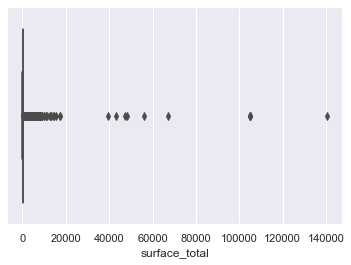

In [57]:
print(caba.surface_total.describe())
sns.boxplot(caba.surface_total)
plt.show()

count     79702.000000
mean         88.688042
std         965.750244
min           0.000000
25%          39.000000
50%          54.000000
75%          80.000000
max      104890.000000
Name: surface_covered, dtype: float64


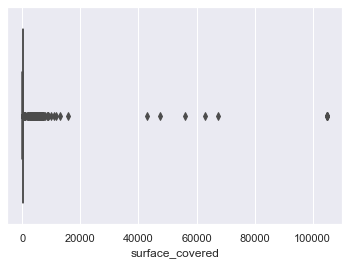

In [58]:
print(caba.surface_covered.describe())
sns.boxplot(caba.surface_covered)
plt.show()

count    7.970200e+04
mean     2.464933e+05
std      3.310692e+05
min      5.000000e+03
25%      1.050000e+05
50%      1.550000e+05
75%      2.500000e+05
max      9.477000e+06
Name: price, dtype: float64


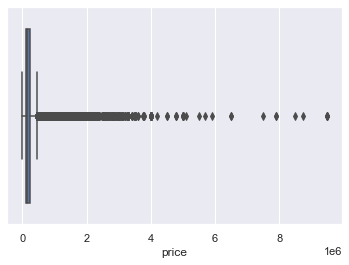

In [59]:
print(caba.price.describe())
sns.boxplot(caba.price)
plt.show()

<AxesSubplot:xlabel='rooms', ylabel='surface_covered'>

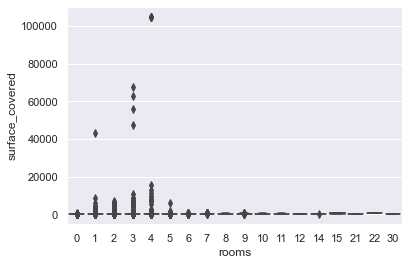

In [60]:
sns.boxplot(data=caba, x='rooms', y='surface_covered')

<AxesSubplot:xlabel='bedrooms', ylabel='surface_covered'>

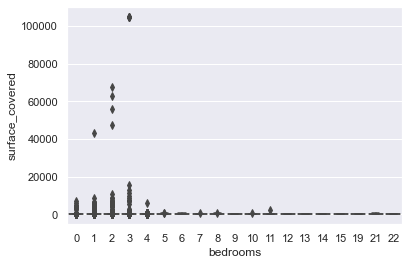

In [61]:
sns.boxplot(data=caba, x='bedrooms', y='surface_covered')

<AxesSubplot:xlabel='bathrooms', ylabel='surface_covered'>

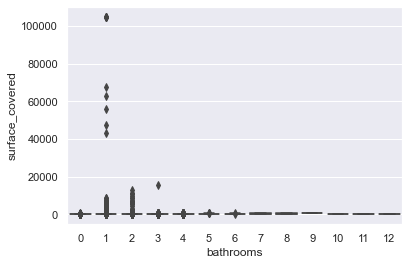

In [62]:
sns.boxplot(data=caba, x='bathrooms', y='surface_covered')

### 8) Tratamiento de valores minimos y outliers

Considerante la superficie cubierta, tomamos como valor minimo 18 m2 ya que es el valor minimo establecido por el gobierno de la ciudad y como valor maximo seleccionamos todos los datos del cuartil 99 para eliminar el outlier que vimos en el grafico anterior.

Respecto a precio por m2, tomamos como valor maximo U$S 10.000 ya que es el maximo valor en paginas de ventas de departamentos

In [63]:
LS = caba.surface_covered.quantile(0.99)
LI = 18
LS_precio = caba.price.quantile(0.99)
LS_sup_total = caba.surface_total.quantile(0.99)

caba = caba[(caba.surface_covered <= LS) &
            (caba.surface_covered >= LI) &
            (caba.price <= LS_precio) &
            (caba.surface_total <= LS_sup_total) &
            (caba.rooms <= 9) &
            (caba.bedrooms <= 8) &
            (caba.bathrooms <= 5)
            ]

count    7.788600e+04
mean     2.196923e+05
std      2.096906e+05
min      5.000000e+03
25%      1.050000e+05
50%      1.520000e+05
75%      2.450000e+05
max      1.690000e+06
Name: price, dtype: float64


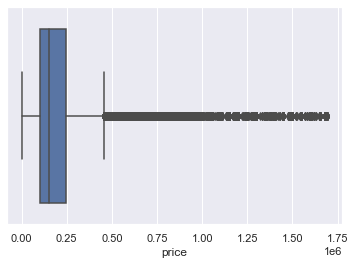

In [64]:
print(caba.price.describe())
sns.boxplot(caba.price)
plt.show()

count    77886.000000
mean        67.215363
std         43.324635
min         18.000000
25%         39.000000
50%         54.000000
75%         80.000000
max        332.000000
Name: surface_covered, dtype: float64


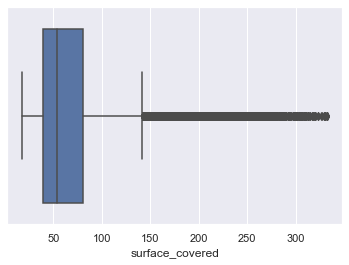

In [65]:
print(caba.surface_covered.describe())
sns.boxplot(caba.surface_covered)
plt.show()

count    77886.000000
mean        75.587513
std         49.297591
min         18.000000
25%         42.000000
50%         60.000000
75%         90.000000
max        384.000000
Name: surface_total, dtype: float64


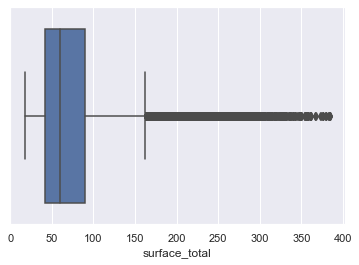

In [66]:
print(caba.surface_total.describe())
sns.boxplot(caba.surface_total)
plt.show()

<AxesSubplot:xlabel='rooms', ylabel='surface_covered'>

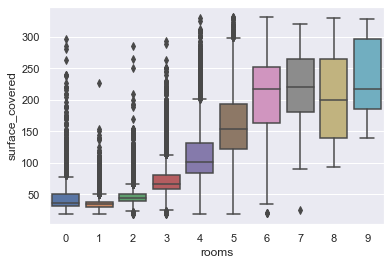

In [67]:
sns.boxplot(data=caba, x='rooms', y='surface_covered')

<AxesSubplot:xlabel='bedrooms', ylabel='surface_covered'>

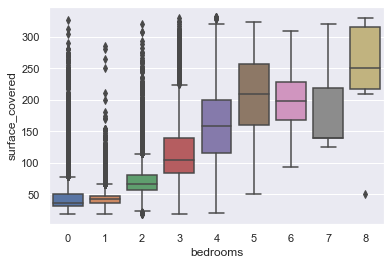

In [68]:
sns.boxplot(data=caba, x='bedrooms', y='surface_covered')

<AxesSubplot:xlabel='bathrooms', ylabel='surface_covered'>

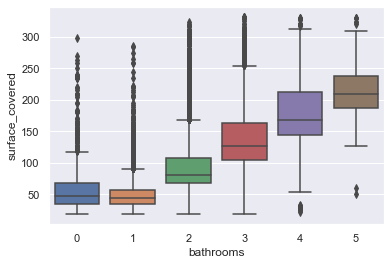

In [69]:
sns.boxplot(data=caba, x='bathrooms', y='surface_covered')

### 9) Imputacion de valores nulos

In [70]:
#Reemplazamos a nan los valores reemplazados por cero
caba.rooms.replace(0, np.nan, inplace=True)
caba.bedrooms.replace(0, np.nan, inplace=True)
caba.bathrooms.replace(0, np.nan, inplace=True)

In [71]:
caba.isnull().sum() / caba.shape[0] * 100

barrios             0.000000
lat                 6.185964
lon                 6.185964
surface_total       0.000000
surface_covered     0.000000
price               0.000000
rooms               1.802635
bedrooms           21.082094
bathrooms           1.744858
Pileta             89.361374
Cochera            70.708471
Parrilla           78.699638
sum                75.813368
dtype: float64

In [72]:
#Imputamos la media de lat lon por barrio
caba['lat'] = caba['lat'].fillna(caba.groupby('barrios')['lat'].transform('mean'))
caba['lon'] = caba['lon'].fillna(caba.groupby('barrios')['lon'].transform('mean'))

In [73]:
#Usamos qcut para dividir en 9 la superficie cubierta y asignar la cantidad de ambientes en cada division a los nan
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
superficie = pd.qcut(caba.surface_covered, 9, labels=labels)
caba['division'] = superficie

a = caba.loc[caba.division == '1'].fillna(value={'rooms': 1})
b = caba.loc[caba.division == '2'].fillna(value={'rooms': 2})
c = caba.loc[caba.division == '3'].fillna(value={'rooms': 3})
d = caba.loc[caba.division == '4'].fillna(value={'rooms': 4})
e = caba.loc[caba.division == '5'].fillna(value={'rooms': 5})
f = caba.loc[caba.division == '6'].fillna(value={'rooms': 6})
g = caba.loc[caba.division == '7'].fillna(value={'rooms': 7})
h = caba.loc[caba.division == '8'].fillna(value={'rooms': 8})
i = caba.loc[caba.division == '9'].fillna(value={'rooms': 9})

caba = pd.concat([a,b,c,d,e,f,g,h,i])
caba.drop(columns='division', inplace=True)

#Mismo procedimiento para asignar bedrooms
labels = ['1', '2', '3', '4', '5', '6', '7', '8']
superficie = pd.qcut(caba.surface_covered, 8, labels=labels)
caba['division'] = superficie

a = caba.loc[caba.division == '1'].fillna(value={'bedrooms': 1})
b = caba.loc[caba.division == '2'].fillna(value={'bedrooms': 2})
c = caba.loc[caba.division == '3'].fillna(value={'bedrooms': 3})
d = caba.loc[caba.division == '4'].fillna(value={'bedrooms': 4})
e = caba.loc[caba.division == '5'].fillna(value={'bedrooms': 5})
f = caba.loc[caba.division == '6'].fillna(value={'bedrooms': 6})
g = caba.loc[caba.division == '7'].fillna(value={'bedrooms': 7})
h = caba.loc[caba.division == '8'].fillna(value={'bedrooms': 8})

caba = pd.concat([a,b,c,d,e,f,g,h])
caba.drop(columns='division', inplace=True)

#Mismo procedimiento para asignar bathrooms
labels = ['1', '2', '3', '4', '5']
superficie = pd.qcut(caba.surface_covered, 5, labels=labels)
caba['division'] = superficie

a = caba.loc[caba.division == '1'].fillna(value={'bathrooms': 1})
b = caba.loc[caba.division == '2'].fillna(value={'bathrooms': 2})
c = caba.loc[caba.division == '3'].fillna(value={'bathrooms': 3})
d = caba.loc[caba.division == '4'].fillna(value={'bathrooms': 4})
e = caba.loc[caba.division == '5'].fillna(value={'bathrooms': 5})

caba = pd.concat([a,b,c,d,e])
caba.drop(columns='division', inplace=True)


In [74]:
#Transformamos las 3 columnas en int
cols = ['rooms', 'bedrooms', 'bathrooms']

for col in cols:
    caba[col]= pd.to_numeric(caba[col], downcast='integer')


In [75]:
caba.isnull().sum() / caba.shape[0]*100

barrios             0.000000
lat                 0.000000
lon                 0.000000
surface_total       0.000000
surface_covered     0.000000
price               0.000000
rooms               0.000000
bedrooms            0.000000
bathrooms           0.000000
Pileta             89.361374
Cochera            70.708471
Parrilla           78.699638
sum                75.813368
dtype: float64

In [76]:
print('Dataset final con', caba.shape[0], 'datos')

Dataset final con 77886 datos


### 10) Cercania a diferentes puntos de la ciudad

En este seccion usamos datos abiertos que provee el Gobierno de la Ciudad de Buenos Aires en https://data.buenosaires.gob.ar/
Usamos la formula de Haversiana para determinar la distancia entre los departamentos a la venta con diferentes puntos de la ciudad:
* Estaciones de subte
* Paradas de colectivos
* Paradas de metrobuses
* Estaciones de trenes
* Estaciones de ecobicis
* Espacios culturales
* Espacios gastronimicos
* Universidades
* Polideportivos
* Hospitales
* Comisarias
* Espacios verdes

Se considera que el departamento se encuentra "cerca" de alguno de estos puntos mencionados si su distancia no supera hasta los 2 kms.

#### Formula Haversiana

In [77]:
def haversine_np(lon1, lat1, lon2, lat2):
  
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6361 * c  
    
    return km

#### Subte

In [78]:
subte_path = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/subte-estaciones/estaciones-de-subte.csv"
subte = pd.read_csv(subte_path) 

In [79]:
latlon = caba[['lat','lon']]  
latlon_subte = subte[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_subte['long'],latlon_subte['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'subte'] = "Cerca"
    else:
        latlon_.loc[index, 'subte'] = "Lejos"
caba = pd.concat([caba,latlon_['subte']],axis=1)     

In [80]:
mask_subte = caba['subte'] == "Cerca"
dummies_subte = pd.get_dummies(mask_subte, prefix='subte', drop_first=True)
caba = caba.join(dummies_subte)
caba.drop(columns='subte', inplace=True)

#### Colectivos

In [81]:
bondis_path = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/colectivos/paradas-de-colectivo.csv"
bondis = pd.read_csv(bondis_path) 

In [82]:
bondis = bondis.rename({
    'stop_lat': 'lat',
    'stop_lon': 'long',
}, axis=1)

In [83]:
latlon = caba[['lat','lon']] 
latlon_bondis = bondis[['long','lat']] 
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_bondis['long'],latlon_bondis['lat'])
    if any(distancia < 0.5):
        latlon_.loc[index, 'bus'] = "Cerca"
    else:
        latlon_.loc[index, 'bus'] = "Lejos"
caba = pd.concat([caba,latlon_['bus']],axis=1) 

In [84]:
mask_bondi = caba['bus'] == "Cerca"
dummies_bondi = pd.get_dummies(mask_bondi, prefix='bus', drop_first=True)
caba = caba.join(dummies_bondi)
caba.drop(columns='bus', inplace=True)

#### Metrobus

In [85]:
metrobus_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/metrobus/estaciones-de-metrobus.csv'
metrobus = pd.read_csv(metrobus_path) 

In [86]:
metrobus['WKT'] = metrobus['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(metrobus, geometry='WKT')

In [87]:
metrobus['long'] = gdf.geometry.x
metrobus['lat'] = gdf.geometry.y

In [88]:
latlon = caba[['lat','lon']]  
latlon_metrobus = metrobus[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_metrobus['long'],latlon_metrobus['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'metrobus'] = "Cerca"
    else:
        latlon_.loc[index, 'metrobus'] = "Lejos"
caba = pd.concat([caba,latlon_['metrobus']],axis=1)    

In [89]:
mask_metrobus = caba['metrobus'] == "Cerca"
dummies_metrobus = pd.get_dummies(mask_metrobus, prefix='metrobus', drop_first=True)
caba = caba.join(dummies_metrobus)
caba.drop(columns='metrobus', inplace=True)

#### Tren

In [90]:
tren_path = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/estaciones-de-ferrocarril/estaciones-de-ferrocarril.csv"
tren = pd.read_csv(tren_path) 

In [91]:
latlon = caba[['lat','lon']]  
latlon_tren = tren[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_tren['long'],latlon_tren['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'tren'] = "Cerca"
    else:
        latlon_.loc[index, 'tren'] = "Lejos"
caba = pd.concat([caba,latlon_['tren']],axis=1)     

In [92]:
mask_tren = caba['tren'] == "Cerca"
dummies_tren = pd.get_dummies(mask_tren, prefix='tren', drop_first=True)
caba = caba.join(dummies_tren)
caba.drop(columns='tren', inplace=True)

#### Ecobici

In [93]:
bici_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/estaciones-bicicletas-publicas/nuevas-estaciones-bicicletas-publicas.csv'
bici = pd.read_csv(bici_path) 

In [94]:
bici['WKT'] = bici['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(bici, geometry='WKT')

In [95]:
bici['long'] = gdf.geometry.x
bici['lat'] = gdf.geometry.y

In [96]:
latlon = caba[['lat','lon']] 
latlon_bici = bici[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_bici['long'],latlon_bici['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'ecobici'] = "Cerca"
    else:
        latlon_.loc[index, 'ecobici'] = "Lejos"
caba = pd.concat([caba,latlon_['ecobici']],axis=1)    

In [97]:
mask_bici = caba['ecobici'] == "Cerca"
dummies_bici = pd.get_dummies(mask_bici, prefix='ecobici', drop_first=True)
caba = caba.join(dummies_bici)
caba.drop(columns='ecobici', inplace=True)

#### Espacios culturales

In [98]:
ec_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/espacios-culturales/espacios-culturales.csv'
ec = pd.read_csv(ec_path) 

In [99]:
latlon = caba[['lat','lon']]  
latlon_ec = ec[['longitud','latitud']] 
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_ec['longitud'],latlon_ec['latitud'])
    if any(distancia < 2):
        latlon_.loc[index, 'espacios_culturales'] = "Cerca"
    else:
        latlon_.loc[index, 'espacios_culturales'] = "Lejos"
caba = pd.concat([caba,latlon_['espacios_culturales']],axis=1)     

In [100]:
mask_ec = caba['espacios_culturales'] == "Cerca"
dummies_ec = pd.get_dummies(mask_ec, prefix='espacios_culturales', drop_first=True)
caba = caba.join(dummies_ec)
caba.drop(columns='espacios_culturales', inplace=True)

#### Establecimientos gastronomicos

In [101]:
eg_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/oferta-gastronomica/establecimientos_gastronomicos.csv'
eg = pd.read_csv(eg_path) 

In [102]:
latlon =caba[['lat','lon']]  
latlon_eg = eg[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_eg['long'],latlon_eg['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'gastronomico'] = "Cerca"
    else:
        latlon_.loc[index, 'gastronomico'] = "Lejos"
caba = pd.concat([caba,latlon_['gastronomico']],axis=1)     

In [103]:
mask_eg = caba['gastronomico'] == "Cerca"
dummies_eg = pd.get_dummies(mask_eg, prefix='gastronomico', drop_first=True)
caba = caba.join(dummies_eg)
caba.drop(columns='gastronomico', inplace=True)

#### Universidades

In [104]:
uni_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/universidades/universidades.csv'
uni = pd.read_csv(uni_path) 


In [105]:
latlon = caba[['lat','lon']]  
latlon_uni = uni[['long','lat']] 
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_uni['long'],latlon_uni['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'universidad'] = "Cerca"
    else:
        latlon_.loc[index, 'universidad'] = "Lejos"
caba = pd.concat([caba,latlon_['universidad']],axis=1)     # cambiar aca dataset final a usar

In [106]:
mask_uni = caba['universidad'] == "Cerca"
dummies_uni = pd.get_dummies(mask_uni, prefix='universidad', drop_first=True)
caba = caba.join(dummies_uni)
caba.drop(columns='universidad', inplace=True)

#### Polideportivos

In [107]:
poli_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/polideportivos/polideportivos.csv'
poli = pd.read_csv(poli_path) 

In [108]:
latlon = caba[['lat','lon']] 
latlon_poli = poli[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_poli['long'],latlon_poli['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'polideportivo'] = "Cerca"
    else:
        latlon_.loc[index, 'polideportivo'] = "Lejos"
caba = pd.concat([caba,latlon_['polideportivo']],axis=1)     # cambiar aca dataset final a usar

In [109]:
mask_poli = caba['polideportivo'] == "Cerca"
dummies_poli = pd.get_dummies(mask_poli, prefix='polideportivo', drop_first=True)
caba = caba.join(dummies_poli)
caba.drop(columns='polideportivo', inplace=True)

#### Hospitales

In [110]:
hospitales_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/salud/hospitales/hospitales.csv'
hospitales = pd.read_csv(hospitales_path) 

In [111]:
hospitales['WKT'] = hospitales['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(hospitales, geometry='WKT')

In [112]:
hospitales['long'] = gdf.geometry.x
hospitales['lat'] = gdf.geometry.y

In [113]:
latlon = caba[['lat','lon']] 
latlon_hospital = hospitales[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_hospital['long'],latlon_hospital['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'hospital'] = "Cerca"
    else:
        latlon_.loc[index, 'hospital'] = "Lejos"
caba = pd.concat([caba,latlon_['hospital']],axis=1)     

In [114]:
mask_hospital = caba['hospital'] == "Cerca"
dummies_hospital = pd.get_dummies(mask_hospital, prefix='hospital', drop_first=True)
caba = caba.join(dummies_hospital)
caba.drop(columns='hospital', inplace=True)

#### Comisarias

In [115]:
comisarias_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/comisarias-policia-de-la-ciudad/comisarias-policia-de-la-ciudad.csv'
comisarias = pd.read_csv(comisarias_path) 

In [116]:
latlon = caba[['lat','lon']]  
latlon_comisaria = comisarias[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_comisaria['long'],latlon_comisaria['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'comisaria'] = "Cerca"
    else:
        latlon_.loc[index, 'comisaria'] = "Lejos"
caba = pd.concat([caba,latlon_['comisaria']],axis=1)     

In [117]:
mask_comisaria = caba['comisaria'] == "Cerca"
dummies_comisaria = pd.get_dummies(mask_comisaria, prefix='comisaria', drop_first=True)
caba = caba.join(dummies_comisaria)
caba.drop(columns='comisaria', inplace=True)

#### Espacios verdes

In [118]:
verdes_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/espacios-verdes/espacio-verde-publico.csv'
verdes = pd.read_csv(verdes_path) 

In [119]:
verdes['WKT'] = verdes['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(verdes, geometry='WKT')

In [120]:
verdes['long'] = gdf.centroid.geometry.x
verdes['lat'] = gdf.centroid.geometry.y

In [121]:
latlon = caba[['lat','lon']]  
latlon_verdes = verdes[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_verdes['long'],latlon_verdes['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'espacios_verdes'] = "Cerca"
    else:
        latlon_.loc[index, 'espacios_verdes'] = "Lejos"
caba = pd.concat([caba,latlon_['espacios_verdes']],axis=1)     

In [122]:
mask_verde = caba['espacios_verdes'] == "Cerca"
dummies_verde = pd.get_dummies(mask_verde, prefix='espacios_verdes', drop_first=True)
caba = caba.join(dummies_verde)
caba.drop(columns='espacios_verdes', inplace=True)

### 11) Dummies de variables categoricas

#### Barrios

In [125]:
dummies_barrio = pd.get_dummies(caba.barrios, drop_first=True)
caba = caba.join(dummies_barrio)
caba.drop(columns='barrios', inplace=True)

#### Pileta

In [126]:
mask_pileta = caba['Pileta'] == 'Pileta'
dummies_pileta = pd.get_dummies(mask_pileta, prefix='pileta', drop_first=True)
caba = caba.join(dummies_pileta)
caba.drop(columns='Pileta', inplace=True)

#### Cochera

In [127]:
mask_cochera = caba['Cochera'] == 'Cochera'
dummies_cochera = pd.get_dummies(mask_cochera,prefix='cochera', drop_first=True)
caba = caba.join(dummies_cochera)
caba.drop(columns='Cochera', inplace=True)

#### Parrilla

In [128]:
mask_parrilla = caba['Parrilla'] == 'Parrilla'
dummies_parrilla = pd.get_dummies(mask_parrilla,prefix='parrilla', drop_first=True)
caba = caba.join(dummies_parrilla)
caba.drop(columns='Parrilla', inplace=True)

#### SUM

In [129]:
mask_sum = caba['sum'] == 'SUM'
dummies_sum = pd.get_dummies(mask_sum,prefix='sum', drop_first=True)
caba = caba.join(dummies_sum)
caba.drop(columns='sum', inplace=True)

### Exterior

In [130]:
mask_uncovered = (caba['surface_total'] - caba['surface_covered']) > 0
dummies_exterior = pd.get_dummies(mask_uncovered, prefix='Exterior', drop_first=True)
caba = caba.join(dummies_exterior)

### 12) Correlacion

In [131]:
caba.corr()

,lat,lon,surface_total,surface_covered,price,rooms,bedrooms,bathrooms,subte_True,bus_True,...,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,pileta_True,cochera_True,parrilla_True,sum_True,Exterior_True
lat,1.000000,-0.201302,0.107445,0.102812,0.193620,0.051786,0.005355,0.111542,0.099832,-0.001073,...,-0.030140,-0.045823,-0.066366,0.181182,-0.058353,0.094127,0.133476,0.110884,0.097443,0.058466
lon,-0.201302,1.000000,0.146655,0.181833,0.206220,0.107172,0.043380,0.096722,0.428950,-0.011162,...,-0.007688,-0.075096,-0.008053,-0.301719,-0.187760,-0.018987,-0.029009,-0.132939,-0.092531,-0.128434
surface_total,0.107445,0.146655,1.000000,0.945445,0.814337,0.749273,0.530667,0.702962,0.040501,-0.004385,...,0.001332,-0.014474,-0.004228,-0.044865,-0.026526,0.036552,0.275469,0.005078,-0.011244,0.093862
surface_covered,0.102812,0.181833,0.945445,1.000000,0.830843,0.765400,0.538830,0.712809,0.055769,-0.004886,...,0.001494,-0.016976,-0.003087,-0.056930,-0.031079,0.035948,0.268287,-0.032154,-0.014878,-0.019038
price,0.193620,0.206220,0.814337,0.830843,1.000000,0.561757,0.372997,0.673203,0.038533,-0.011861,...,-0.003758,-0.023512,-0.017503,-0.043398,-0.043481,0.145388,0.351986,0.049373,0.094437,0.018838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pileta_True,0.094127,-0.018987,0.036552,0.035948,0.145388,-0.046052,-0.045486,0.062219,0.004390,0.002473,...,0.003338,-0.010458,-0.007522,0.021754,-0.010666,1.000000,0.185643,0.332276,0.273245,0.030362
cochera_True,0.133476,-0.029009,0.275469,0.268287,0.351986,0.170152,0.116711,0.277483,-0.032149,0.000676,...,-0.004613,0.004183,-0.012737,0.053914,-0.008087,0.185643,1.000000,0.268631,0.211752,0.084866
parrilla_True,0.110884,-0.132939,0.005078,-0.032154,0.049373,-0.113084,-0.064276,0.031991,-0.018809,0.003728,...,-0.003728,0.011461,-0.011342,0.073377,-0.000155,0.332276,0.268631,1.000000,0.396143,0.123382
sum_True,0.097443,-0.092531,-0.011244,-0.014878,0.094437,-0.108672,-0.053283,0.040578,-0.025915,0.004048,...,-0.004048,-0.003946,-0.012314,0.049934,0.015758,0.273245,0.211752,0.396143,1.000000,0.078394


<AxesSubplot:>

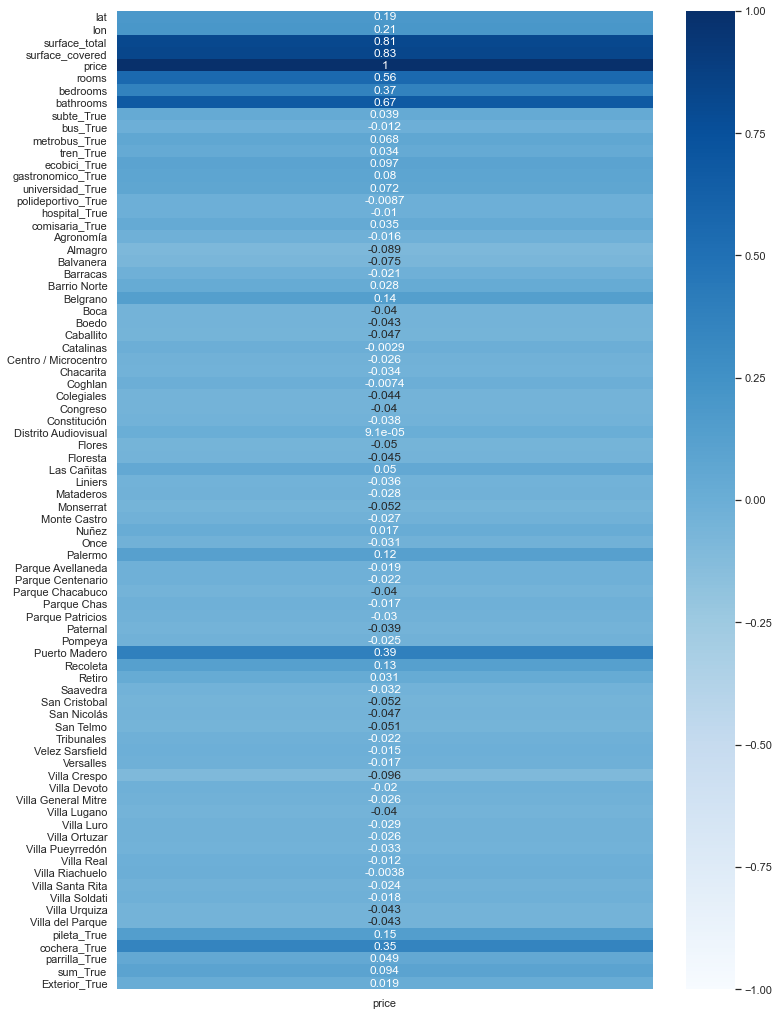

In [132]:
plt.figure(figsize=(12,18))
sns.heatmap(caba.corr()[['price']], annot=True, vmin=-1, cmap='Blues')

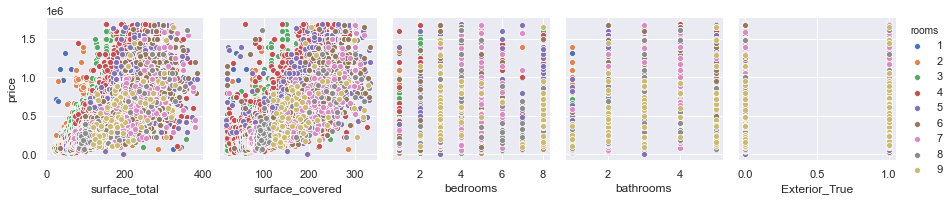

In [134]:
sns.pairplot(data=caba,hue='rooms', y_vars='price',\
             x_vars=['surface_total','surface_covered','bedrooms', 'bathrooms', 'Exterior_True'])

### 13) Modelo de regresion

Combinando GridSearchCV y Pipeline vamos a crear diferentes modelos:
* Regresion Linear
* Modelo de Lasso
* Modelo de Ridge
* Modelo de Elastic Net
* Random Forest Regressor
* AdaBoosting
* Gradient Boosting
* LightGBM Regressor

Al final vamos a presentar en un dataframe cada uno de sus scores (R2) para verificar cual fue el modelo que tuvo una mejor performance.

In [135]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn import linear_model
set_config(display='diagram')

In [136]:
caba.columns

Index(['lat', 'lon', 'surface_total', 'surface_covered', 'price', 'rooms',
       'bedrooms', 'bathrooms', 'subte_True', 'bus_True', 'metrobus_True',
       'tren_True', 'ecobici_True', 'gastronomico_True', 'universidad_True',
       'polideportivo_True', 'hospital_True', 'comisaria_True', 'Agronomía',
       'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca',
       'Boedo', 'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita',
       'Coghlan', 'Colegiales', 'Congreso', 'Constitución',
       'Distrito Audiovisual', 'Flores', 'Floresta', 'Las Cañitas', 'Liniers',
       'Mataderos', 'Monserrat', 'Monte Castro', 'Nuñez', 'Once', 'Palermo',
       'Parque Avellaneda', 'Parque Centenario', 'Parque Chacabuco',
       'Parque Chas', 'Parque Patricios', 'Paternal', 'Pompeya',
       'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra', 'San Cristobal',
       'San Nicolás', 'San Telmo', 'Tribunales', 'Velez Sarsfield',
       'Versalles', 'Villa Crespo', 'Villa De

In [137]:
caba.shape

(77886, 80)

In [138]:
X = caba.drop(columns=['price','lat','lon'])
y = caba.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

folds = 5

#### Regresion Linear

In [139]:
lr = LinearRegression()

param_lr ={'normalize':[True, False]}

grid_lr = GridSearchCV(estimator=lr, param_grid=param_lr, cv=folds, scoring='r2')
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'normalize': [True, False]}, scoring='r2')

In [140]:
grid_lr.best_score_

0.8075859568760715

In [141]:
grid_lr.best_estimator_

LinearRegression()

#### Ridge

In [142]:
pasos = [('preprocesamiento', StandardScaler()),
         ('regresion', Ridge())
        ]

pipe_grid_rid = Pipeline(pasos)

param_grid_rid = [{'preprocesamiento':[StandardScaler()],
                   'regresion__alpha':[0.01, 0.3, 0.5, 0.7, 0.8],
                }]

grid_rid = GridSearchCV(estimator=pipe_grid_rid, param_grid=param_grid_rid, cv=folds, scoring='r2')
grid_rid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', Ridge())]),
             param_grid=[{'preprocesamiento': [StandardScaler()],
                          'regresion__alpha': [0.01, 0.3, 0.5, 0.7, 0.8]}],
             scoring='r2')

In [143]:
grid_rid.best_score_

0.8075859691068947

In [144]:
grid_rid.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion', Ridge(alpha=0.8))])

#### Lasso

In [145]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', Lasso(max_iter=5000, tol=0.001))
        ]

pipe_grid_lass = Pipeline(pasos)

param_grid_lass = [{'preprocesamiento':[StandardScaler()],
                    'regresion__alpha':[0.01, 0.3, 0.5, 0.7, 0.8],
                  }]

grid_lass = GridSearchCV(estimator=pipe_grid_lass, param_grid=param_grid_lass, cv=folds, scoring='r2')
grid_lass.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion',
                                        Lasso(max_iter=5000, tol=0.001))]),
             param_grid=[{'preprocesamiento': [StandardScaler()],
                          'regresion__alpha': [0.01, 0.3, 0.5, 0.7, 0.8]}],
             scoring='r2')

In [146]:
grid_lass.best_score_

0.807586084786546

In [147]:
grid_lass.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion', Lasso(alpha=0.8, max_iter=5000, tol=0.001))])

#### ElasticNet

In [148]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', ElasticNet(max_iter=10000, tol=0.001))
        ]

pipe_grid_en = Pipeline(pasos)

param_grid_en = [{'preprocesamiento':[StandardScaler()],
                  'regresion__alpha':[0.01, 0.3, 0.5, 0.7, 0.8],
                  'regresion__l1_ratio':[0.01, 0.3, 0.5, 0.7, 0.8],
                }]

grid_en = GridSearchCV(estimator=pipe_grid_en, param_grid=param_grid_en, cv=folds, scoring='r2')
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion',
                                        ElasticNet(max_iter=10000,
                                                   tol=0.001))]),
             param_grid=[{'preprocesamiento': [StandardScaler()],
                          'regresion__alpha': [0.01, 0.3, 0.5, 0.7, 0.8],
                          'regresion__l1_ratio': [0.01, 0.3, 0.5, 0.7, 0.8]}],
             scoring='r2')

In [149]:
grid_en.best_score_

0.8075792861879005

In [150]:
grid_en.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 ElasticNet(alpha=0.01, l1_ratio=0.8, max_iter=10000,
                            tol=0.001))])

#### Random Forest

In [151]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', RandomForestRegressor())
        ]

pipe_grid_rf = Pipeline(pasos)

param_grid_rf = [{'preprocesamiento':[StandardScaler()],
                  'regresion__n_estimators': [500, 1000],
                  'regresion__max_depth': [5, 10]
                }]

grid_rf = GridSearchCV(estimator=pipe_grid_rf, param_grid=param_grid_rf, cv=folds, scoring='r2')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', RandomForestRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler()],
                          'regresion__max_depth': [5, 10],
                          'regresion__n_estimators': [500, 1000]}],
             scoring='r2')

In [152]:
grid_rf.best_score_

0.8832432851407678

In [153]:
grid_rf.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 RandomForestRegressor(max_depth=10, n_estimators=500))])

#### Gradient Boosting Regressor

In [154]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', GradientBoostingRegressor())
        ]

pipe_grid_gb = Pipeline(pasos)

param_grid_gb = [{'preprocesamiento':[StandardScaler()],
                  'regresion__n_estimators': [500, 1000],
                  'regresion__max_depth': [5, 10]
                }]

grid_gb = GridSearchCV(estimator=pipe_grid_gb, param_grid=param_grid_gb, cv=folds, scoring='r2')
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion',
                                        GradientBoostingRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler()],
                          'regresion__max_depth': [5, 10],
                          'regresion__n_estimators': [500, 1000]}],
             scoring='r2')

In [155]:
grid_gb.best_score_

0.9126413916463051

In [156]:
grid_gb.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 GradientBoostingRegressor(max_depth=10, n_estimators=1000))])

#### Ada Boost Regressor

In [157]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', AdaBoostRegressor())
        ]

pipe_grid_ab = Pipeline(pasos)

param_grid_ab = [{'preprocesamiento':[StandardScaler()],
                  'regresion__n_estimators': [500, 1000],
                  'regresion__learning_rate':[0.01, 0.1, 0.3, 1]
                }]

grid_ab = GridSearchCV(estimator=pipe_grid_ab, param_grid=param_grid_ab, cv=folds, scoring='r2')
grid_ab.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', AdaBoostRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler()],
                          'regresion__learning_rate': [0.01, 0.1, 0.3, 1],
                          'regresion__n_estimators': [500, 1000]}],
             scoring='r2')

In [158]:
grid_ab.best_score_

0.7472790950341227

In [159]:
grid_ab.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 AdaBoostRegressor(learning_rate=0.01, n_estimators=500))])

#### LightGBM Regressor

In [160]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', LGBMRegressor())
        ]

pipe_grid_lg = Pipeline(pasos)

param_grid_lg = [{'preprocesamiento':[StandardScaler()],
                  'regresion__n_estimators': [500, 100],
                  'regresion__learning_rate':[0.01, 0.1, 0.3, 1]
                }]

grid_lg = GridSearchCV(estimator=pipe_grid_lg, param_grid=param_grid_lg, cv=folds, scoring='r2')
grid_lg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', LGBMRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler()],
                          'regresion__learning_rate': [0.01, 0.1, 0.3, 1],
                          'regresion__n_estimators': [500, 100]}],
             scoring='r2')

In [161]:
grid_lg.best_score_

0.9092660761816646

In [162]:
grid_lg.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 LGBMRegressor(learning_rate=0.3, n_estimators=500))])

### 14) Resultado de los modelos

In [163]:
resultados = pd.DataFrame({'Modelos':['Regresion Linear', 'Ridge', 'Lasso', 'Elastic Net','Random', 'Gradient Boost', 'AdaBoost', 'LightGBM'],
                           'R2':[grid_lr.best_score_, grid_rid.best_score_, grid_lass.best_score_, grid_en.best_score_, grid_rf.best_score_, grid_gb.best_score_,\
                                 grid_ab.best_score_, grid_lg.best_score_]
                         })
resultados.sort_values(by='R2', ascending=False)

,Modelos,R2
5,Gradient Boost,0.912641
7,LightGBM,0.909266
4,Random,0.883243
2,Lasso,0.807586
1,Ridge,0.807586
0,Regresion Linear,0.807586
3,Elastic Net,0.807579
6,AdaBoost,0.747279


### 15) R2 Score usando en test

In [169]:
test = pd.DataFrame({'Modelos':['Regresion Linear', 'Ridge', 'Lasso', 'Elastic Net','Random', 'Gradient Boost', 'AdaBoost', 'LightGBM'],
                     'R2 en Test':[grid_lr.score(X_test, y_test),\
                                   grid_rid.score(X_test, y_test),\
                                   grid_lass.score(X_test, y_test),\
                                   grid_en.score(X_test, y_test),\
                                   grid_rf.score(X_test, y_test),\
                                   grid_gb.score(X_test, y_test),\
                                   grid_ab.score(X_test, y_test),\
                                   grid_lg.score(X_test, y_test)]
                    })
test.sort_values(by='R2', ascending=False)

,Modelos,R2
5,Gradient Boost,0.926901
7,LightGBM,0.922241
4,Random,0.894181
2,Lasso,0.811144
0,Regresion Linear,0.811143
1,Ridge,0.811143
3,Elastic Net,0.811080
6,AdaBoost,0.760669
